# Deep Q-learning for GridWorld - Complete code


In [1]:
import numpy as np
import torch
import torch.nn as nn
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
from Gridworld import Gridworld
import copy
import os

##### Vanilla Model

In [2]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

##### Function to test the model

##### Experience Replay to eliminate Catastrophic forgetting

In [3]:
l1 = 29
l2 = 64
l3 = 32
l4 = 5

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

###### Target network to handle learning instability

## DQN Training with Experience Replay and Target Network

In [4]:
# Create main network and target network
model2 = copy.deepcopy(model)  # Target network

# Loss function and optimizer
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training hyperparameters
gamma = 0.99      # Discount factor
epsilon = 1.0     # Initial exploration rate
epsilon_min = 0.1 # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for exploration

In [ ]:
# Enhanced Compound Training Function
def train_compound(epochs=20000, batch_size=64, memory_size=100000, render_interval=500):
    # Initialize metrics tracking
    losses = []
    all_rewards = []
    avg_rewards = []
    success_rates = []
    best_eval_score = float('-inf')
    best_model_state = None
    
    # Create replay memory
    replay = deque(maxlen=memory_size)
    
    # Create model checkpoint directory
    os.makedirs('models', exist_ok=True)

    # Initialize epsilon for exploration
    epsilon = 1.0
    epsilon_min = 0.05
    epsilon_decay_rate = 0.99995  # Slower decay for more exploration
    
    # Set up curriculum - progression from very simple to complex environments
    curriculum = [
        # Stage 1: Very small grids (5x5, 6x6) with minimal obstacles
        {'episodes': int(epochs * 0.05), 'grid_sizes': [5, 6], 'obstacles': (1, 3), 'patterns': ['random'], 
         'max_steps_factor': 3, 'epsilon_min': 0.2},
        
        # Stage 2: Small grids (7x7, 8x8) with few obstacles
        {'episodes': int(epochs * 0.1), 'grid_sizes': [7, 8], 'obstacles': (2, 5), 'patterns': ['random'], 
         'max_steps_factor': 3, 'epsilon_min': 0.15},
        
        # Stage 3: Medium-small grids (10x10, 12x12) with more obstacles
        {'episodes': int(epochs * 0.15), 'grid_sizes': [10, 12], 'obstacles': (4, 8), 'patterns': ['random', 'clusters'],
         'max_steps_factor': 2.5, 'epsilon_min': 0.1},
        
        # Stage 4: Medium grids (15x15, 18x18) with more complexity
        {'episodes': int(epochs * 0.2), 'grid_sizes': [15, 18], 'obstacles': (6, 12), 'patterns': ['random', 'clusters'],
         'max_steps_factor': 2.5, 'epsilon_min': 0.1},
        
        # Stage 5: Large grids (20x20, 25x25) with challenging obstacles
        {'episodes': int(epochs * 0.2), 'grid_sizes': [20, 25], 'obstacles': (10, 20), 'patterns': ['random', 'clusters', 'walls'],
         'max_steps_factor': 2.2, 'epsilon_min': 0.08},
        
        # Stage 6: Very large grids (30x30, 35x35) with complex obstacles
        {'episodes': int(epochs * 0.15), 'grid_sizes': [30, 35], 'obstacles': (15, 30), 'patterns': ['random', 'clusters', 'walls'],
         'max_steps_factor': 2.0, 'epsilon_min': 0.05},
        
        # Stage 7: Extremely large grids (40x40) with many obstacles
        {'episodes': int(epochs * 0.15), 'grid_sizes': [40], 'obstacles': (20, 40), 'patterns': ['random', 'clusters', 'walls'],
         'max_steps_factor': 2.0, 'epsilon_min': 0.05}
    ]
    
    # Setup for periodic evaluation
    eval_interval = 200  # Evaluate model every 200 episodes
    eval_episodes = 20   # Number of episodes to use for evaluation
    
    # Validation environments for consistent evaluation
    validation_envs = [
        # Simple validation environments
        (10, 5, 'random'),   # (grid_size, obstacles, pattern)
        (15, 10, 'random'),
        (20, 15, 'clusters'),
        (30, 20, 'walls'),
        (40, 30, 'random')
    ]

    # Define sync frequency for target network updates (steps)
    sync_freq = 1000
    
    # Global step counter
    global_step = 0
    episode_count = 0
    
    print("Starting compound training with curriculum learning...")
    
    # Loop through curriculum stages
    for stage_idx, stage in enumerate(curriculum):
        print(f"\n===== Starting Stage {stage_idx + 1}/{len(curriculum)} =====")
        print(f"Grid sizes: {stage['grid_sizes']}")
        print(f"Obstacles: {stage['obstacles']}")
        print(f"Patterns: {stage['patterns']}")
        print(f"Episodes: {stage['episodes']}")
        
        # Update epsilon min for this stage
        stage_epsilon_min = stage['epsilon_min']
        
        # Reset epsilon for new stage if needed (optional - keep this line if you want epsilon reset per stage)
        epsilon = max(1.0 - stage_idx * 0.1, 0.5)  # Start with less exploration in later stages
        
        # Track episodes in this stage
        stage_episodes = 0
        
        # Continue until we've completed the designated episodes for this stage
        while stage_episodes < stage['episodes'] and episode_count < epochs:
            # Select random parameters for this episode
            grid_size = random.choice(stage['grid_sizes'])
            num_obstacles = random.randint(stage['obstacles'][0], stage['obstacles'][1])
            pattern = random.choice(stage['patterns'])
            
            # Create environment for this episode
            max_steps = int(grid_size * stage['max_steps_factor'])  # Scale max steps with grid size
            game = Gridworld(size=grid_size, mode=pattern, num_obstacles=num_obstacles, max_steps=max_steps)
            
            # Initialize state
            state = game.reset()
            state = torch.from_numpy(state).float().unsqueeze(0)  # Add batch dimension
            
            done = False
            steps = 0
            episode_reward = 0
            success = False
            
            # Display info periodically
            should_render = (episode_count % render_interval == 0)
            
            if episode_count % 50 == 0:
                print(f"Episode {episode_count}/{epochs} (Stage {stage_idx+1}, Ep {stage_episodes}/{stage['episodes']})")
                print(f"Grid: {grid_size}x{grid_size}, Obstacles: {num_obstacles}, Pattern: {pattern}")
                print(f"Epsilon: {epsilon:.4f}, Memory: {len(replay)}/{memory_size}")
            
            # Run episode
            while not done and steps < max_steps:
                steps += 1
                global_step += 1
                
                # Epislon-greedy action selection
                if random.random() < epsilon:
                    action = random.randint(0, 4)  # Random action
                else:
                    with torch.no_grad():
                        q_values = model(state)
                        action = torch.argmax(q_values).item()  # Greedy action
                
                # Take action in environment
                next_state, reward, done, info = game.step(action)
                next_state = torch.from_numpy(next_state).float().unsqueeze(0)
                
                # Record success if goal reached
                if reward > 0:  # Assuming positive reward means goal reached
                    success = True
                
                # Store in replay memory
                replay.append((state, action, reward, next_state, done))
                
                # Update state and accumulate reward
                state = next_state
                episode_reward += reward
                
                # Render if needed
                if should_render and steps % 5 == 0:
                    clear_output(wait=True)
                    game.render()
                    plt.title(f"Stage {stage_idx+1}, Episode {episode_count}, Step {steps}, Reward: {episode_reward:.2f}")
                    plt.pause(0.1)
                
                # Training step (if we have enough samples)
                if len(replay) >= batch_size:
                    # Sample mini-batch
                    minibatch = random.sample(replay, batch_size)
                    
                    # Extract batch components
                    state_batch = torch.cat([s1 for (s1, _, _, _, _) in minibatch])
                    action_batch = torch.tensor([a for (_, a, _, _, _) in minibatch], dtype=torch.long)
                    reward_batch = torch.tensor([r for (_, _, r, _, _) in minibatch], dtype=torch.float)
                    next_state_batch = torch.cat([s2 for (_, _, _, s2, _) in minibatch])
                    done_batch = torch.tensor([d for (_, _, _, _, d) in minibatch], dtype=torch.float)
                    
                    # Compute current Q values
                    current_Q = model(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
                    
                    # Double DQN: Use online network to select actions, target network to evaluate
                    with torch.no_grad():
                        # Find best actions using online model
                        best_actions = model(next_state_batch).max(1)[1].unsqueeze(1)
                        # Evaluate those actions using target model
                        next_Q = model2(next_state_batch).gather(1, best_actions).squeeze(1)
                        # Compute target Q values
                        target_Q = reward_batch + gamma * next_Q * (1 - done_batch)
                    
                    # Compute loss and update model
                    loss = loss_fn(current_Q, target_Q)
                    optimizer.zero_grad()
                    loss.backward()
                    
                    # Gradient clipping to prevent exploding gradients
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                    
                    optimizer.step()
                    
                    # Store loss
                    losses.append(loss.item())
                
                # Update target network
                if global_step % sync_freq == 0:
                    model2.load_state_dict(model.state_dict())
                    print(f"Target network updated at step {global_step}")
            
            # Episode completed
            all_rewards.append(episode_reward)
            
            # Calculate running average reward
            window_size = min(100, len(all_rewards))
            avg_reward = sum(all_rewards[-window_size:]) / window_size
            avg_rewards.append(avg_reward)
            
            # Print episode results
            if success:
                print(f"Episode {episode_count}: Success! Reward: {episode_reward:.2f}, Steps: {steps}")
            elif episode_count % 50 == 0:
                print(f"Episode {episode_count}: Failed. Reward: {episode_reward:.2f}, Steps: {steps}")
            
            # Evaluate periodically
            if episode_count % eval_interval == 0 and episode_count > 0:
                print("\nRunning evaluation...")
                eval_success_rate, eval_avg_reward = evaluate_model(model, validation_envs, episodes_per_env=eval_episodes)
                success_rates.append(eval_success_rate)
                
                print(f"Evaluation - Success rate: {eval_success_rate:.2f}, Avg reward: {eval_avg_reward:.2f}")
                
                # Save best model
                eval_score = eval_success_rate * 10 + eval_avg_reward  # Combined metric
                if eval_score > best_eval_score:
                    best_eval_score = eval_score
                    best_model_state = model.state_dict().copy()
                    print(f"New best model with eval score {eval_score:.2f}!")
                    
                    # Save best model
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epsilon': epsilon,
                        'episode': episode_count,
                        'eval_score': eval_score,
                        'success_rate': eval_success_rate,
                        'avg_reward': eval_avg_reward,
                    }, 'models/dqn_best.pth')
            
            # Checkpoint model periodically
            if episode_count % 500 == 0 and episode_count > 0:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epsilon': epsilon,
                    'episode': episode_count,
                    'stage': stage_idx,
                    'all_rewards': all_rewards,
                    'avg_rewards': avg_rewards,
                    'losses': losses,
                }, f'models/dqn_checkpoint_ep{episode_count}.pth')
                print(f"Checkpoint saved at episode {episode_count}")
            
            # Decay epsilon - but respect the minimum for this stage
            epsilon = max(stage_epsilon_min, epsilon * epsilon_decay_rate)
            
            # Increment counters
            episode_count += 1
            stage_episodes += 1
        
        # End of stage - evaluate and save stage model
        print(f"\n===== Completed Stage {stage_idx + 1}/{len(curriculum)} =====")
        stage_eval_success, stage_eval_reward = evaluate_model(model, validation_envs, episodes_per_env=eval_episodes)
        
        print(f"Stage {stage_idx+1} Evaluation - Success rate: {stage_eval_success:.2f}, Avg reward: {stage_eval_reward:.2f}")
        
        # Save stage model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epsilon': epsilon,
            'episode': episode_count,
            'stage': stage_idx,
            'success_rate': stage_eval_success,
            'avg_reward': stage_eval_reward,
        }, f'models/dqn_stage{stage_idx+1}.pth')
    
    # Training complete - final evaluation with best model
    print("\n===== Training Complete =====")
    
    # Load best model for final evaluation
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model for final evaluation")
    
    # Comprehensive final evaluation
    print("\nRunning final evaluation...")
    final_success_rate, final_avg_reward = evaluate_model(model, validation_envs, episodes_per_env=50)  # More episodes for final eval
    
    print(f"Final Evaluation - Success rate: {final_success_rate:.2f}, Avg reward: {final_avg_reward:.2f}")
    
    # Plot training metrics
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(all_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    
    plt.subplot(2, 2, 2)
    plt.plot(avg_rewards)
    plt.title('Average Reward (100 episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    
    plt.subplot(2, 2, 3)
    plt.plot(losses[-10000:])  # Plot last 10000 losses to see recent trends
    plt.title('Training Loss (last 10000 updates)')
    plt.xlabel('Update Step')
    plt.ylabel('Loss')
    
    if success_rates:
        plt.subplot(2, 2, 4)
        # Generate x values that match exactly with the length of success_rates
        eval_points = np.arange(eval_interval, eval_interval * (len(success_rates) + 1), eval_interval)[:len(success_rates)]
        plt.plot(eval_points, success_rates)
        plt.title('Evaluation Success Rate')
        plt.xlabel('Episode')
        plt.ylabel('Success Rate')
    
    plt.tight_layout()
    plt.savefig('models/training_curves.png')
    plt.show()
    
    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epsilon': epsilon,
        'episode': episode_count,
        'final_success_rate': final_success_rate,
        'final_avg_reward': final_avg_reward,
    }, 'models/dqn_final.pth')
    
    # Return relevant data for analysis
    return {
        'model': model,
        'rewards': all_rewards,
        'avg_rewards': avg_rewards,
        'losses': losses,
        'success_rates': success_rates,
        'final_success_rate': final_success_rate,
        'final_avg_reward': final_avg_reward,
        'best_eval_score': best_eval_score
    }

def evaluate_model(model, env_configs, episodes_per_env=10):
    """
    Evaluate model on multiple environment configurations
    
    Args:
        model: The DQN model to evaluate
        env_configs: List of tuples (grid_size, num_obstacles, pattern)
        episodes_per_env: Number of episodes to run for each environment config
        
    Returns:
        Tuple of (success_rate, average_reward)
    """
    model.eval()  # Set model to evaluation mode
    success_count = 0
    total_rewards = []
    total_episodes = len(env_configs) * episodes_per_env
    
    with torch.no_grad():  # No need to track gradients during evaluation
        for grid_size, num_obstacles, pattern in env_configs:
            print(f"Evaluating on grid {grid_size}x{grid_size}, {num_obstacles} obstacles, {pattern} pattern")
            
            for ep in range(episodes_per_env):
                # Create environment
                max_steps = grid_size * 2
                game = Gridworld(size=grid_size, mode=pattern, num_obstacles=num_obstacles, max_steps=max_steps)
                
                state = game.reset()
                state = torch.from_numpy(state).float().unsqueeze(0)
                
                done = False
                steps = 0
                episode_reward = 0
                success = False
                
                while not done and steps < max_steps:
                    steps += 1
                    
                    # Get action from model - no exploration during evaluation
                    q_values = model(state)
                    action = torch.argmax(q_values).item()
                    
                    # Take action
                    next_state, reward, done, info = game.step(action)
                    next_state = torch.from_numpy(next_state).float().unsqueeze(0)
                    
                    # Update state and reward
                    state = next_state
                    episode_reward += reward
                    
                    # Check for success
                    if reward > 0:  # Positive reward means goal reached
                        success = True
                        break
                
                # Record results
                if success:
                    success_count += 1
                total_rewards.append(episode_reward)
    
    # Calculate final metrics
    success_rate = success_count / total_episodes
    avg_reward = sum(total_rewards) / len(total_rewards)
    
    model.train()  # Set model back to training mode
    return success_rate, avg_reward

epochs = 10000
results = train_compound(epochs=10000, batch_size=64, memory_size=50000, render_interval=500)
model = results['model']

# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epsilon': epsilon,
    'episode': epochs,
}, 'models/dqn_final.pth')
print("Training completed. Final model saved.")

Starting compound training with curriculum learning...

===== Starting Stage 1/7 =====
Grid sizes: [5, 6]
Obstacles: (1, 3)
Patterns: ['random']
Episodes: 500


AttributeError: 'Gridworld' object has no attribute 'add_border_walls'

## Testing The Trained Model

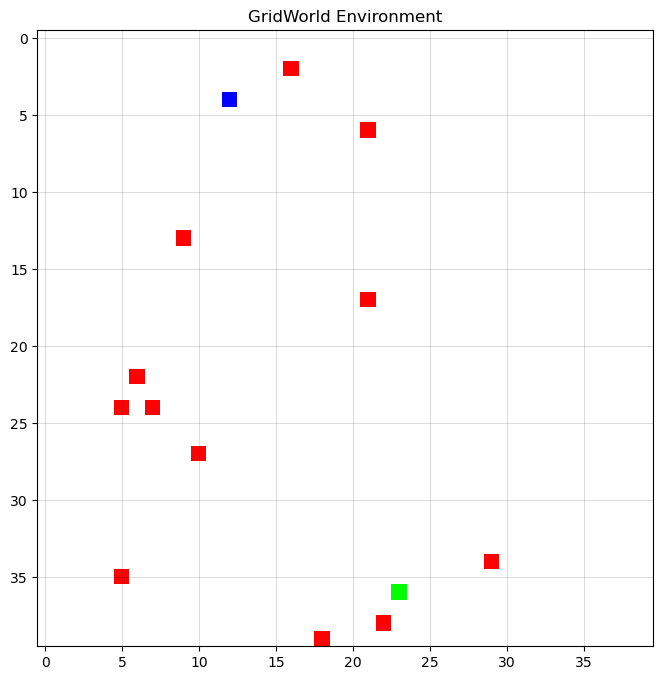

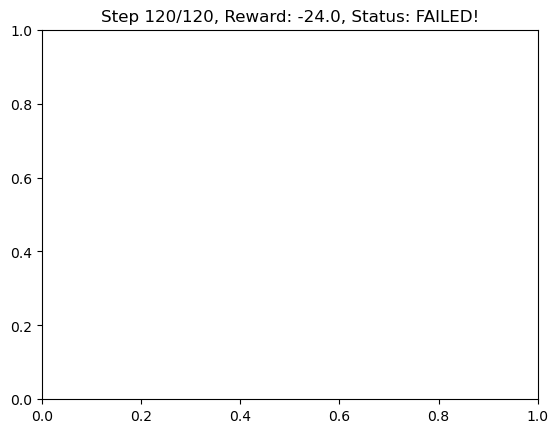


❌ FAILED! Agent did not reach goal after 120 steps. Reward: -24.0
Completed 3/3 episodes. Current success rate: 0.00

===== TEST RESULTS SUMMARY =====
Overall Success Rate: 0.33
Overall Average Steps: 86.00
Overall Average Reward: -19.27

--- Results by Grid Size ---
Size 40×40: Success Rate 0.33, Avg Steps 86.00, Avg Reward -19.27


In [ ]:
# Clear testing function with visualization and proper return values
def test_model(size=40, mode='random', obstacles=30, max_steps=150, 
               render=True, pause_time=0.1):
    """
    Test a single episode with the current model
    
    Args:
        size: Grid size (default 15)
        mode: Obstacle pattern - 'random', 'clusters', or 'walls' (default 'random')
        obstacles: Number of obstacles (default 10)
        max_steps: Maximum steps allowed (default 50)
        render: Whether to render the environment (default True)
        pause_time: Time to pause between renders (default 0.1)
        
    Returns:
        bool: True if agent reached goal, False otherwise
        int: Number of steps taken
        float: Total reward accumulated
    """
    # Set model to evaluation mode
    model.eval()
    
    # Create environment
    game = Gridworld(size=size, mode=mode, num_obstacles=obstacles, max_steps=max_steps)
    
    # Initialize state
    state = game.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    
    # Print initial positions if rendering
    if render:
        print(f"\nStarting test: {size}x{size} grid, {obstacles} obstacles, {mode} pattern")
        print(f"Agent at {game.player_position}, Goal at {game.goal_position}")
        print(f"Manhattan distance: {abs(game.player_position[0] - game.goal_position[0]) + abs(game.player_position[1] - game.goal_position[1])}")
    
    # Run episode
    done = False
    steps = 0
    total_reward = 0
    success = False
    
    while not done and steps < max_steps:
        # Select action
        with torch.no_grad():
            q_values = model(state)
            action = torch.argmax(q_values).item()
        
        # Take action
        next_state, reward, done, info = game.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        
        # Update state and tracking variables
        state = next_state
        total_reward += reward
        steps += 1
        
        # Check for success
        if reward > 0:  # Positive reward means reached goal
            success = True
            done = True
        
        # Render if requested
        if render and (steps % 2 == 0 or done):  # Render every other step
            clear_output(wait=True)
            game.render()
            status = "SUCCESS!" if success else ("FAILED!" if done else "In progress...")
            plt.title(f"Step {steps}/{max_steps}, Reward: {total_reward:.1f}, Status: {status}")
            plt.pause(pause_time)
    
    # Final status message
    if render:
        if success:
            print(f"\n✅ SUCCESS! Goal reached in {steps} steps with reward {total_reward:.1f}")
        else:
            print(f"\n❌ FAILED! Agent did not reach goal after {steps} steps. Reward: {total_reward:.1f}")
    
    return success, steps, total_reward

# Function to run multiple test episodes and collect statistics
def run_test_suite(model_path=None, num_episodes=50, grid_sizes=None, render_one=True):
    """
    Run a comprehensive test suite on the model
    
    Args:
        model_path: Path to model to load (None to use current model)
        num_episodes: Total number of episodes to test (default 50)
        grid_sizes: List of grid sizes to test (default [10, 20, 40])
        render_one: Whether to render one episode per configuration (default True)
        
    Returns:
        dict: Test results by grid size and overall
    """
    # Load model if path provided
    if model_path:
        try:
            checkpoint = torch.load(model_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded model from {model_path}")
        except FileNotFoundError:
            print(f"⚠️ Model not found at {model_path}, using current model")
    
    # Set evaluation mode
    model.eval()
    
    # Define test configurations if not provided
    if grid_sizes is None:
        grid_sizes = [10, 20, 40]
    
    # Create test environments
    test_configs = []
    for size in grid_sizes:
        # Scale obstacles and steps based on grid size
        easy_obstacles = max(3, int(size * 0.1))
        medium_obstacles = max(5, int(size * 0.2))
        hard_obstacles = max(8, int(size * 0.3))
        max_steps = size * 3
        
        # Add configurations for this grid size
        test_configs.extend([
            {"size": size, "obstacles": easy_obstacles, "mode": "random", "max_steps": max_steps},
            {"size": size, "obstacles": medium_obstacles, "mode": "clusters", "max_steps": max_steps},
            {"size": size, "obstacles": hard_obstacles, "mode": "walls", "max_steps": max_steps}
        ])
    
    # Results tracking
    results = {
        "overall": {"success": 0, "episodes": 0, "total_steps": 0, "total_reward": 0},
        "by_size": {size: {"success": 0, "episodes": 0, "total_steps": 0, "total_reward": 0} for size in grid_sizes},
        "by_config": {}
    }
    
    # Distribute episodes across configurations
    episodes_per_config = max(1, num_episodes // len(test_configs))
    total_episodes = episodes_per_config * len(test_configs)
    
    print(f"Starting test suite with {total_episodes} total episodes across {len(test_configs)} configurations")
    print(f"Testing grid sizes: {grid_sizes}")
    
    # Test each configuration
    for config_idx, config in enumerate(test_configs):
        size = config["size"]
        mode = config["mode"]
        obstacles = config["obstacles"]
        max_steps = config["max_steps"]
        
        # Create config key
        config_key = f"{size}x{size}_{mode}_{obstacles}"
        results["by_config"][config_key] = {"success": 0, "episodes": 0, "total_steps": 0, "total_reward": 0}
        
        print(f"\n--- Testing Configuration {config_idx+1}/{len(test_configs)}: Size {size}, {obstacles} obstacles, {mode} pattern ---")
        
        # Run episodes for this configuration
        for ep in range(episodes_per_config):
            # Determine if we should render this episode
            should_render = render_one and ep == 0
            
            # Run test episode
            success, steps, reward = test_model(
                size=size, 
                mode=mode,
                obstacles=obstacles, 
                max_steps=max_steps,
                render=should_render,
                pause_time=0.05 if should_render else 0
            )
            
            # Update results
            results["overall"]["episodes"] += 1
            results["overall"]["success"] += 1 if success else 0
            results["overall"]["total_steps"] += steps
            results["overall"]["total_reward"] += reward
            
            results["by_size"][size]["episodes"] += 1
            results["by_size"][size]["success"] += 1 if success else 0
            results["by_size"][size]["total_steps"] += steps
            results["by_size"][size]["total_reward"] += reward
            
            results["by_config"][config_key]["episodes"] += 1
            results["by_config"][config_key]["success"] += 1 if success else 0
            results["by_config"][config_key]["total_steps"] += steps
            results["by_config"][config_key]["total_reward"] += reward
            
            # Print progress
            if (ep + 1) % 5 == 0 or ep == episodes_per_config - 1:
                success_rate = results["by_config"][config_key]["success"] / (ep + 1)
                print(f"Completed {ep+1}/{episodes_per_config} episodes. Current success rate: {success_rate:.2f}")
    
    # Calculate final statistics
    # Overall stats
    results["overall"]["success_rate"] = results["overall"]["success"] / results["overall"]["episodes"]
    results["overall"]["avg_steps"] = results["overall"]["total_steps"] / results["overall"]["episodes"]
    results["overall"]["avg_reward"] = results["overall"]["total_reward"] / results["overall"]["episodes"]
    
    # Stats by grid size
    for size in grid_sizes:
        size_data = results["by_size"][size]
        size_data["success_rate"] = size_data["success"] / size_data["episodes"]
        size_data["avg_steps"] = size_data["total_steps"] / size_data["episodes"]
        size_data["avg_reward"] = size_data["total_reward"] / size_data["episodes"]
    
    # Stats by configuration
    for config_key, config_data in results["by_config"].items():
        config_data["success_rate"] = config_data["success"] / config_data["episodes"]
        config_data["avg_steps"] = config_data["total_steps"] / config_data["episodes"]
        config_data["avg_reward"] = config_data["total_reward"] / config_data["episodes"]
    
    # Print summary
    print("\n===== TEST RESULTS SUMMARY =====")
    print(f"Overall Success Rate: {results['overall']['success_rate']:.2f}")
    print(f"Overall Average Steps: {results['overall']['avg_steps']:.2f}")
    print(f"Overall Average Reward: {results['overall']['avg_reward']:.2f}")
    
    print("\n--- Results by Grid Size ---")
    for size in grid_sizes:
        size_data = results["by_size"][size]
        print(f"Size {size}×{size}: Success Rate {size_data['success_rate']:.2f}, " +
              f"Avg Steps {size_data['avg_steps']:.2f}, Avg Reward {size_data['avg_reward']:.2f}")
    
    return results

# Usage example:
# Load and test the final model
results = run_test_suite(model_path='models/dqn_final.pth', 
                         num_episodes=10,  # 30 episodes per grid size
                         grid_sizes=[40],
                         render_one=True)

# To test without loading a saved model (using the current model):
# results = run_test_suite(num_episodes=90, grid_sizes=[10, 20, 40])